In [43]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt

import gensim

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('averaged_perceptron_tagger')

from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.models import Sequential
from keras import layers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [44]:
df = pd.read_csv('true.txt')

Split training data into text and classification labels

In [45]:
docs = df['text']
labels = df['class']

Pre-processing

In [46]:
stopwords = stopwords.words('english')
pronouns = ['i', 'me', 'myself', 'my', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', "he's", 'him', 'his', 'himself',
            'she', "she's", 'her', 'hers', 'herself']
stopwords = [sw for sw in stopwords if sw not in pronouns]

lemmatizer = WordNetLemmatizer()

In [47]:
def translate_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_text(data):
    #remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*', re.IGNORECASE)
    data = pattern.sub('', data)

    #remove URLs
    url = re.compile(r'https?://\S+|www\.S+')
    data = url.sub(r'', data)
    
    #remove emails
    data = re.sub('\S*@\S*\s?', '', data)
    
    #remove punctuation
    translator = re.compile('[%s]' % re.escape(string.punctuation))
    data = translator.sub(' ', data)

    #remove new line characters
    data = re.sub('\s+', ' ', data)
    
    #lowercase text
    data = data.lower()

    return data

def lemmatize_text(data):
    #create tokens
    word_tokens = word_tokenize(data)
    pos_tagged = nltk.pos_tag(word_tokens)
    word_tagged = list(map(lambda x: (x[0], translate_tag(x[1])), pos_tagged))
    lemmatized_data = []
    for word, tag in word_tagged:
        if tag is None:
            lemmatized_data.append(word)
        else:
            lemmatized_data.append(lemmatizer.lemmatize(word, tag))
    text = ' '.join(lemmatized_data)
    return text

In [48]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [49]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [50]:
temp = []
data_to_list = docs.values
for i in range(len(docs)):
    data = clean_text(data_to_list[i])
    data = lemmatize_text(data)
    temp.append(data)

In [9]:
RAND_STATE = 1
#splitting train : test to 70 : 30 ratio
docs_train, docs_test, labels_train, labels_test = train_test_split(temp, labels, train_size=0.7, test_size=0.3 , shuffle=True, random_state=RAND_STATE)

In [10]:
train_words = list(sent_to_words(docs_train))
test_words = list(sent_to_words(docs_test))

In [11]:
train_docs_list = []
for i in range(len(train_words)):
    train_docs_list.append(detokenize(train_words[i]))

In [12]:
test_docs_list = []
for i in range(len(test_words)):
    test_docs_list.append(detokenize(test_words[i]))

In [13]:
max_words = 5000
max_len = 200

In [14]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_docs_list)
tokenizer.fit_on_texts(test_docs_list)
train_sequences = tokenizer.texts_to_sequences(train_docs_list)
test_sequences = tokenizer.texts_to_sequences(test_docs_list)
train_tweets = pad_sequences(train_sequences, maxlen=max_len)
test_tweets = pad_sequences(test_sequences, maxlen=max_len)

In [15]:
embedding_layer = Embedding(1000, 64)

In [16]:
mod_labels_train = to_categorical(labels_train, 3)
mod_labels_test = to_categorical(labels_test, 3)

In [17]:
print(mod_labels_train.shape)
print(labels_train.shape)
print(mod_labels_test.shape)
print(labels_test.shape)

(97157, 3)
(97157,)
(41640, 3)
(41640,)


In [18]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20)) #the embedding layer
model1.add(layers.LSTM(15,dropout=0.5)) #our LSTM layer
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(train_tweets, mod_labels_train, epochs=5, validation_data=(test_tweets, mod_labels_test), callbacks=[checkpoint1])

Epoch 1/5
3037/3037 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9157
Epoch 1: val_accuracy improved from -inf to 0.92325, saving model to best_model1.hdf5
3037/3037 [==============================] - 164s 53ms/step - loss: 0.1905 - accuracy: 0.9157 - val_loss: 0.1594 - val_accuracy: 0.9232
Epoch 2/5
3037/3037 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9254
Epoch 2: val_accuracy improved from 0.92325 to 0.92776, saving model to best_model1.hdf5
3037/3037 [==============================] - 161s 53ms/step - loss: 0.1598 - accuracy: 0.9254 - val_loss: 0.1543 - val_accuracy: 0.9278
Epoch 3/5
3036/3037 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9271
Epoch 3: val_accuracy improved from 0.92776 to 0.92944, saving model to best_model1.hdf5
3037/3037 [==============================] - 161s 53ms/step - loss: 0.1543 - accuracy: 0.9271 - val_loss: 0.1495 - val_accuracy: 0.9294
Epoch 4/5
3036/3037 [================

In [19]:
prediction1_probs = model1.predict(test_tweets)
prediction1_classes = np.argmax(prediction1_probs, axis=1)

1302/1302 [==============================] - 13s 10ms/step


In [20]:
# precision tp / (tp + fp)
precision = precision_score(labels_test, prediction1_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(labels_test, prediction1_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels_test, prediction1_classes, average='micro')
print('F1 score: %f' % f1)

Precision: 0.928987
Recall: 0.928987
F1 score: 0.928987


In [21]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))

model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(train_tweets, mod_labels_train, epochs=5,validation_data=(test_tweets, mod_labels_test),callbacks=[checkpoint2])

Epoch 1/5
3037/3037 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9166
Epoch 1: val_accuracy improved from -inf to 0.92075, saving model to best_model2.hdf5
3037/3037 [==============================] - 296s 96ms/step - loss: 0.1864 - accuracy: 0.9166 - val_loss: 0.1611 - val_accuracy: 0.9207
Epoch 2/5
3037/3037 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9250
Epoch 2: val_accuracy improved from 0.92075 to 0.92872, saving model to best_model2.hdf5
3037/3037 [==============================] - 287s 95ms/step - loss: 0.1603 - accuracy: 0.9250 - val_loss: 0.1514 - val_accuracy: 0.9287
Epoch 3/5
3037/3037 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9280
Epoch 3: val_accuracy improved from 0.92872 to 0.92911, saving model to best_model2.hdf5
3037/3037 [==============================] - 288s 95ms/step - loss: 0.1531 - accuracy: 0.9280 - val_loss: 0.1480 - val_accuracy: 0.9291
Epoch 4/5
3037/3037 [================

In [22]:
prediction2_probs = model2.predict(test_tweets)
prediction2_classes = np.argmax(prediction2_probs, axis=1)

1302/1302 [==============================] - 23s 17ms/step


In [23]:
# precision tp / (tp + fp)
precision = precision_score(labels_test, prediction2_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(labels_test, prediction2_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels_test, prediction2_classes, average='micro')
print('F1 score: %f' % f1)

Precision: 0.930067
Recall: 0.930067
F1 score: 0.930067


In [24]:
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))

model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

history = model3.fit(train_tweets, mod_labels_train, epochs=5,validation_data=(test_tweets, mod_labels_test))

Epoch 1/5
3037/3037 [==============================] - 42s 13ms/step - loss: 0.3263 - acc: 0.8841 - val_loss: 0.2431 - val_acc: 0.9113
Epoch 2/5
3037/3037 [==============================] - 39s 13ms/step - loss: 0.2153 - acc: 0.9160 - val_loss: 0.2075 - val_acc: 0.9166
Epoch 3/5
3037/3037 [==============================] - 41s 13ms/step - loss: 0.2029 - acc: 0.9178 - val_loss: 0.2039 - val_acc: 0.9173
Epoch 4/5
3037/3037 [==============================] - 39s 13ms/step - loss: 0.1978 - acc: 0.9181 - val_loss: 0.1992 - val_acc: 0.9171
Epoch 5/5
3037/3037 [==============================] - 39s 13ms/step - loss: 0.1944 - acc: 0.9182 - val_loss: 0.1950 - val_acc: 0.9174


In [25]:
prediction3_probs = model3.predict(test_tweets)
prediction3_classes = np.argmax(prediction3_probs, axis=1)

1302/1302 [==============================] - 4s 3ms/step


In [26]:
# precision tp / (tp + fp)
precision = precision_score(labels_test, prediction3_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(labels_test, prediction3_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels_test, prediction3_classes, average='micro')
print('F1 score: %f' % f1)

Precision: 0.917363
Recall: 0.917363
F1 score: 0.917363


In [28]:
reports = []
reports.append(precision_recall_fscore_support(labels_test, prediction1_classes))
reports.append(precision_recall_fscore_support(labels_test, prediction2_classes))
reports.append(precision_recall_fscore_support(labels_test, prediction3_classes))
print(reports)

[(array([0.93957509, 0.60417947, 0.97600834]), array([0.9806914 , 0.32723036, 0.91852094]), array([0.95969306, 0.42453034, 0.94639245]), array([35580,  3004,  3056])), (array([0.93855648, 0.62638889, 0.97133106]), array([0.98313659, 0.30026631, 0.93128272]), array([0.96032944, 0.40594059, 0.9508854 ]), array([35580,  3004,  3056])), (array([0.91582944, 0.        , 0.93769257]), array([0.99662732, 0.        , 0.89626963]), array([0.9545216, 0.       , 0.9165133]), array([35580,  3004,  3056]))]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
model_names = ['LSTM Layer', 'Bidirectional Layer', '1D Convolutional Neural Network']

In [31]:
def compare_models(reports, score, legend=True): 
    score_idx = 0
    match score: 
        case 'precision': 
            score_idx = 0
        case 'recall': 
            score_idx = 1
        case 'f1-beta': 
            score_idx = 2
        case 'support': 
            score_idx = 3
        case _: 
            score_idx = 0
  
    class_names = ['normal', 'risk to others', 'risk to self']
    models_precision = [rep[score_idx] for rep in reports]
    class_models_precision = dict(zip(model_names,
                                    np.asarray([rep[score_idx] 
                                                for rep in reports])))


    x = np.arange(len(class_names))  # the label locations
    width = 0.30  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in class_models_precision.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(score)
    ax.set_title(f'{score} of models by class')
    ax.set_xticks(x + width, class_names)
    if legend: 
        ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.2)
    plt.show()

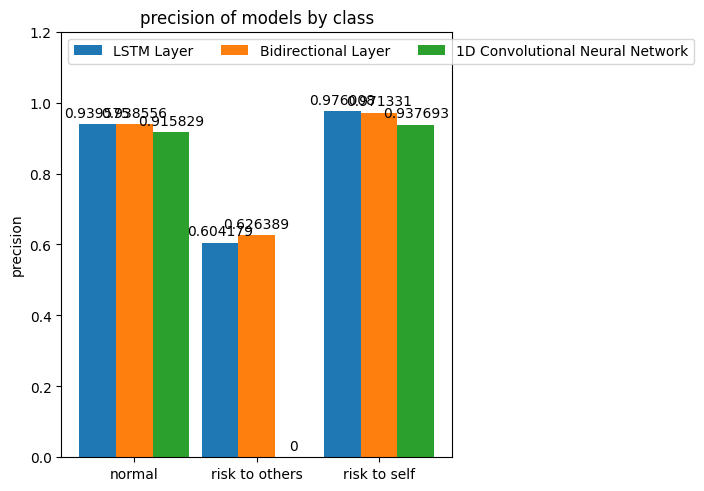

In [32]:
compare_models(reports, 'precision')

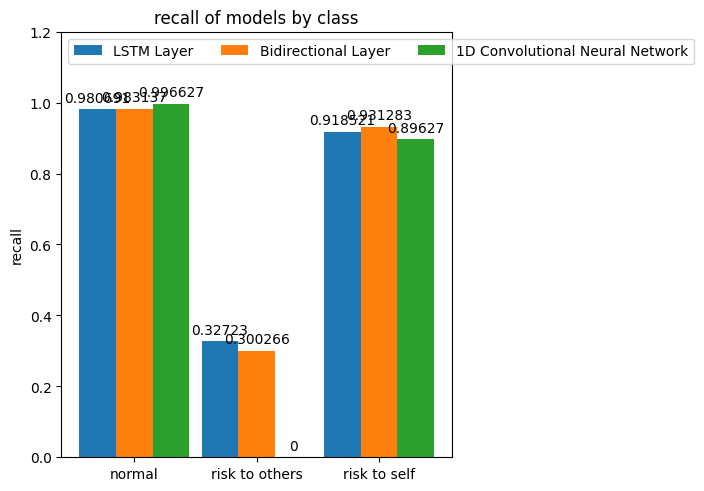

In [33]:
compare_models(reports, 'recall')

In [36]:
cm1 = confusion_matrix(labels_test, prediction1_classes)
print(cm1)
cm2 = confusion_matrix(labels_test, prediction2_classes)
print(cm2)
cm3 = confusion_matrix(labels_test, prediction3_classes)
print(cm3)

[[34893   636    51]
 [ 2003   983    18]
 [  241     8  2807]]
[[34980   535    65]
 [ 2083   902    19]
 [  207     3  2846]]
[[35460     0   120]
 [ 2942     0    62]
 [  317     0  2739]]


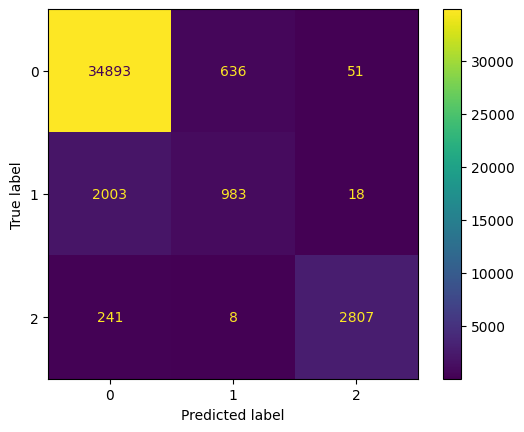

In [38]:
ConfusionMatrixDisplay.from_predictions(labels_test, prediction1_classes)